In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict, List, Tuple
from pathlib import Path
import yaml

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用
from tqdm import tqdm
from contextlib import contextmanager
from time import time

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

from mykaggle.metric.mse import rmsle
from mykaggle.util.ml_logger import MLLogger
from mykaggle.lib.lgbm_util import compute_importances, save_importances
from mykaggle.util.routine import fix_seed

sns.set_style('darkgrid')

In [2]:
settings = yaml.safe_load('''
name: '013_stratified_kfold'
competition: atmacup8
seed: 1019
training:
    how_fold: 'stratified'
    num_folds: 5
    num_rounds: 1000
    early_stopping_rounds: 100
    verbose_eval: 20
lgbm_params:
    objective: binary
    learning_rate: 0.05
    max_depth: -1
    num_leaves: 31
    colsample_bytree: .7
    metric: "None"
''')

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
fix_seed(settings['seed'])

In [4]:
datadir = Path('../data/')
ckptdir = Path('../ckpt/') / settings['name']
if not ckptdir.exists():
    ckptdir.mkdir()

In [5]:
df_train = pd.read_csv(datadir / 'id_train.csv')
df_test = pd.read_csv(datadir / 'id_test.csv')
df_submission = pd.read_csv(datadir / 'atmaCup8_sample-submission.csv')
df_train.shape, df_test.shape

((8359, 17), (8360, 12))

In [6]:
df_train.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,id
0,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,Traveller's Tales,E10+,0
1,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,Traveller's Tales,E10+,1
2,LEGO Batman: The Videogame,PSP,NaN,Action,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,Traveller's Tales,E10+,2
3,Combat,2600,NaN,Action,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,NaN,NaN,3
4,LEGO Harry Potter: Years 5-7,Wii,NaN,Action,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,Traveller's Tales,E10+,4


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='Global_Sales', ylabel='Density'>

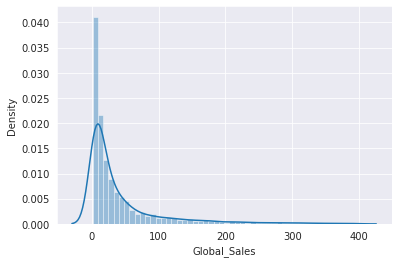

In [7]:
sns.distplot(df_train[df_train['Global_Sales'] < 400]['Global_Sales'])

In [8]:
quantile = df_train.loc[:, 'Global_Sales'].quantile([(i + 1) * 0.1 for i in range(10)])
quantile

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.1       2.0
0.2       5.0
0.3       8.0
0.4      12.0
0.5      18.0
0.6      26.0
0.7      41.0
0.8      67.0
0.9     139.2
1.0    8253.0
Name: Global_Sales, dtype: float64

In [9]:
def sales_to_quantile(x):
    for i, q in enumerate(quantile.values):
        if x <= q:
            return i + 1

In [10]:
df_train['bin_Global_Sales'] = df_train.loc[:, 'Global_Sales'].apply(sales_to_quantile)

In [11]:
splitter = StratifiedKFold(n_splits=5)

In [12]:
y = df_train.loc[:, 'bin_Global_Sales']
splits = splitter.split(df_train, y=y)
splits = list(splits)

In [13]:
for train_idx, valid_idx in splits:
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    print(len(train), len(valid))
    print(train.loc[:, 'Global_Sales'].mean(), valid.loc[:, 'Global_Sales'].mean())
    print(train.loc[:, 'Global_Sales'].median(), valid.loc[:, 'Global_Sales'].median())

6687 1672
62.51278600269179 66.80741626794259
18.0 17.0
6687 1672
64.90279647076417 57.248803827751196
18.0 18.0
6687 1672
61.94825781366831 69.0651913875598
18.0 18.0
6687 1672
62.681770599671005 66.13157894736842
18.0 18.0
6688 1671
64.8132476076555 57.60263315380012
18.0 18.0


/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
import pickle
pickle.dump(splits, open(datadir / 'b_stratified_10fold.pkl', 'wb'))

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 検証

In [ ]:
import pickle
splits = pickle.load(open(datadir / 'group_5fold.pkl', 'rb'))

In [ ]:
for train_idx, valid_idx in splits:
    train, valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    print(train.loc[:, 'Global_Sales'].mean(), valid.loc[:, 'Global_Sales'].mean())
    print(train.loc[:, 'Global_Sales'].median(), valid.loc[:, 'Global_Sales'].median())

In [18]:
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

In [19]:
splits = create_folds(df_train, 'Global_Sales')

In [16]:
splits

/home/jupyter/workspace/atmacup8/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(array([ 164,  594,  790, ..., 8356, 8357, 8358]),
  array([   0,    1,    2, ..., 1685, 1686, 1687])),
 (array([   0,    1,    2, ..., 8356, 8357, 8358]),
  array([ 164,  594,  790, ..., 3354, 3355, 4725])),
 (array([   0,    1,    2, ..., 8356, 8357, 8358]),
  array([1717, 2531, 2532, ..., 5022, 5023, 5024])),
 (array([   0,    1,    2, ..., 8356, 8357, 8358]),
  array([3331, 3487, 3588, ..., 6690, 6691, 6692])),
 (array([   0,    1,    2, ..., 6690, 6691, 6692]),
  array([5352, 5593, 5943, ..., 8356, 8357, 8358]))]